In [365]:
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import auc as calculate_auc
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap, AggMapNet
from aggmap import show, loadmap

In [366]:
dfx = pd.read_excel('./CRC.xlsx', sheet_name='data')
dfx = dfx[dfx.columns[1:]]
dfx = np.log(dfx + 1e-8)


feature_groups_df = pd.read_excel('./CRC.xlsx', sheet_name='feature_info')
feature_group_list = feature_groups_df.Group.tolist()

dfy_all = pd.read_excel('./CRC.xlsx', sheet_name='sample_info')
dfy_all['Country'] = dfy_all.Country.map({'AUS':"AUS", 'CHI':'CHN', 'FRA':'FRA', 'GER':'DEU', 'USA':'USA'})

dfy = pd.get_dummies(dfy_all['Group'])



X = dfx.values.astype(float)
Y = dfy.values.astype(float)


In [367]:
mp = AggMap(dfx, metric = 'correlation')

2022-08-01 19:37:45,015 - INFO - [bidd-aggmap] - Calculating distance ...
2022-08-01 19:37:45,032 - INFO - [bidd-aggmap] - the number of process is 16


100%|#############################################################################################################################################| 849/849 [00:00<00:00, 5217.67it/s]


In [368]:
mp.fit(cluster_channels = 5, verbose = 0,  random_state=888)

2022-08-01 19:38:14,218 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2022-08-01 19:38:14,842 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2022-08-01 19:38:15,845 - INFO - [bidd-aggmap] - Finished


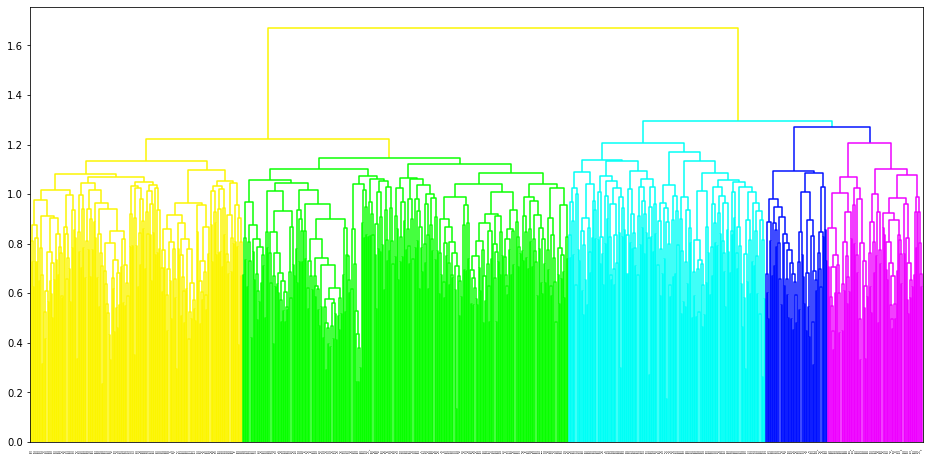

In [369]:
fig_tree = mp.plot_tree(add_leaf_labels = False, leaf_font_size = 2)
fig_tree.savefig('./results/CRC.cluster5_tree.png', bbox_inches='tight', dpi=300)

In [370]:
mp.plot_scatter(enabled_data_labels = False, htmlname = './results/CRC.C5_scatter',radius=5)

2022-08-01 19:38:23,045 - INFO - [bidd-aggmap] - generate file: ././results/CRC.C5_scatter_feature points_849_correlation_umap_scatter
2022-08-01 19:38:23,052 - INFO - [bidd-aggmap] - save html file to ././results/CRC.C5_scatter_feature points_849_correlation_umap_scatter


In [371]:
mp.plot_grid(enabled_data_labels = False, htmlname = './results/CRC_C5.grid')

2022-08-01 19:38:23,067 - INFO - [bidd-aggmap] - generate file: ././results/CRC_C5.grid_feature points_849_correlation_umap_mp
2022-08-01 19:38:23,073 - INFO - [bidd-aggmap] - save html file to ././results/CRC_C5.grid_feature points_849_correlation_umap_mp


In [372]:
X_new = mp.batch_transform(X, scale_method= 'standard')

100%|#############################################################################################################################################| 575/575 [00:00<00:00, 3621.13it/s]


In [373]:
X_new.max(), X_new.min()

(13.37742407389732, -7.332358846794835)

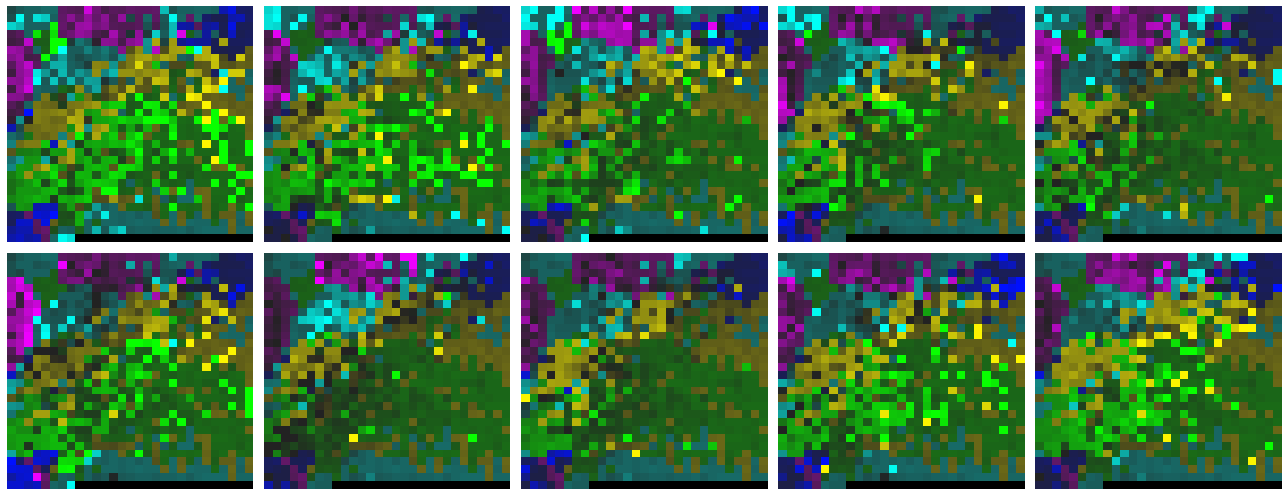

In [374]:
idx = dfy_all.groupby(['Group', 'Country']).apply(lambda x:x.index.tolist())
rows = idx.index.tolist()
idxs = {'CHN': 0, 'DEU':0, 'FRA':0,  'USA': 1, 'AUS': 2}

sns.reset_orig()

n = 5
fontsize = 28

fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(18, 7), sharex = True, sharey = True)

rows = ['CRC', 'CTR']

for row, row_ax in zip(rows, axes):
    
    cidx = idx.loc[row].index     
    for cid, ax in zip(cidx, row_ax):
        pid = idx.loc[row].loc[cid]
        x = X_new[pid[idxs[cid]]]
        show.imshow(x, ax = ax,  mode = 'dark', color_list= pd.Series(mp.colormaps).tolist(), x_max=3, vmin=-0.5, vmax=0.9)
        
# for ax, cid in zip(axes[0], idx.loc['CRC'].index):
#     ax.set_title(cid, fontdict = {'fontsize':fontsize}, loc='center')  
    
# for ax, row_name in zip(axes[:, 0], rows):
#     ax.set_ylabel(row_name, fontsize =fontsize)  
    
fig.tight_layout()
fig.savefig('./results/Country_five_fmaps.pdf', bbox_inches='tight', dpi=400) 

In [375]:
sns.reset_orig()

def plot(rows, fname = './Country1_fmp.png'):

    n = 5
    fontsize = 40

    fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(22,9), sharex = True, sharey = True)

    row_names = [', '.join(i) for i in rows]

    for row, row_ax in zip(rows, axes):
        pidx = idx.loc[row][:n]        
        for pid, ax in zip(pidx, row_ax):
            cid = row[0]
            pid_name = '%s-%s' % (cid, pid)
            x = X_new[pid]
            #ax.imshow(X_new[pid].sum(axis=-1))

            show.imshow(x, ax = ax,  mode = 'dark', color_list= pd.Series(mp.colormaps).tolist(), x_max=3, vmin=-0.5, vmax=0.9)
            ax.set_title(pid_name, fontsize = fontsize) 

    for ax, row in zip(axes[:,0], row_names):
        ax.set_ylabel(row.split(',')[1], fontsize = fontsize)  

    fig.tight_layout()
    fig.savefig(fname, bbox_inches='tight', dpi=400) 

In [376]:
x = X_new[1]

In [377]:
x.max(), x.min()

(4.861834233313788, -3.0363484183551974)

In [378]:
idx = dfy_all.groupby(['Country', 'Group']).apply(lambda x:x.index.tolist())
idx

Country  Group
AUS      CRC      [171, 172, 173, 174, 175, 176, 177, 178, 179, ...
         CTR      [114, 115, 116, 117, 118, 119, 120, 121, 122, ...
CHN      CRC      [223, 224, 225, 226, 227, 228, 229, 230, 232, ...
         CTR      [231, 233, 241, 243, 247, 255, 270, 271, 272, ...
DEU      CRC      [457, 458, 459, 460, 461, 466, 467, 468, 469, ...
         CTR      [455, 456, 462, 463, 464, 465, 471, 473, 474, ...
FRA      CRC      [3, 8, 14, 18, 19, 21, 22, 27, 30, 31, 32, 34,...
         CTR      [0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 1...
USA      CRC      [353, 354, 355, 356, 357, 360, 363, 365, 367, ...
         CTR      [351, 352, 358, 359, 361, 362, 364, 366, 368, ...
dtype: object

## Country-1: 

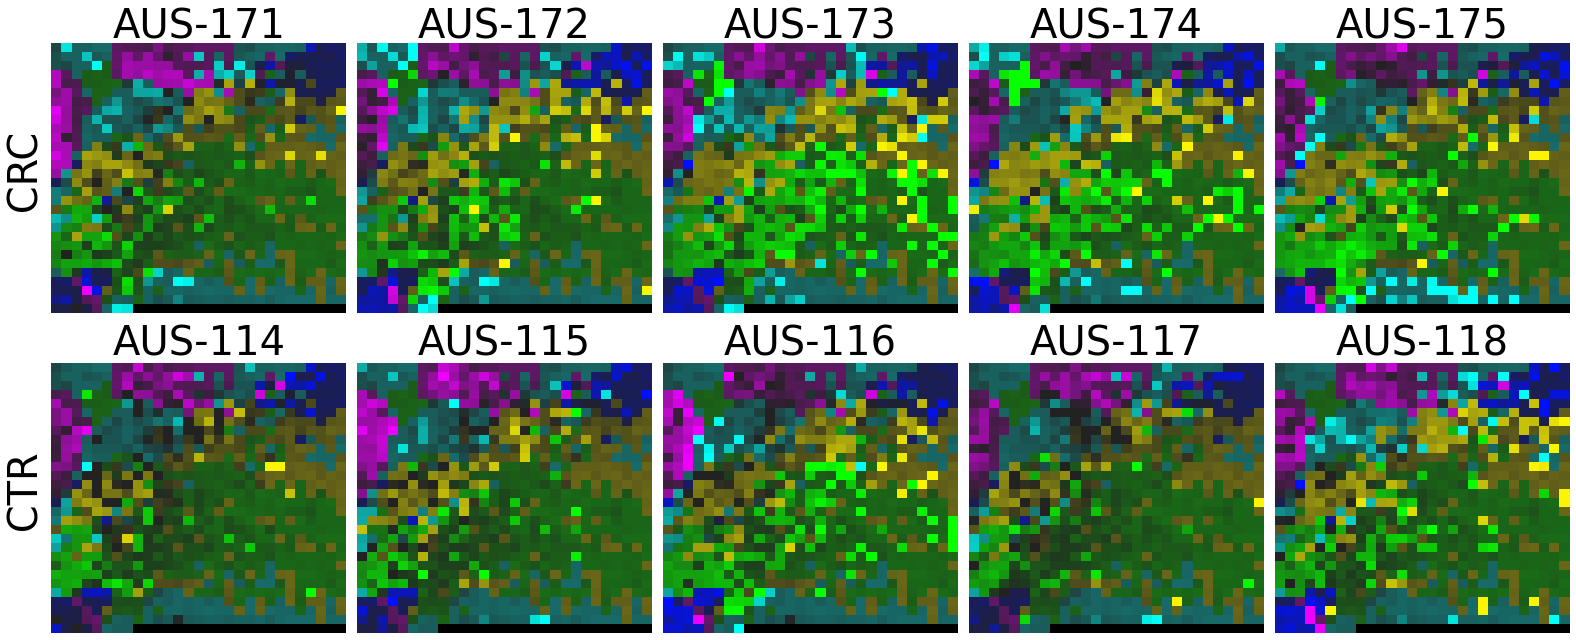

In [379]:
rows = idx.index.tolist()
rows = rows[:2]
plot(rows, fname = './results/Country1_fmp.png')

## Country-2 

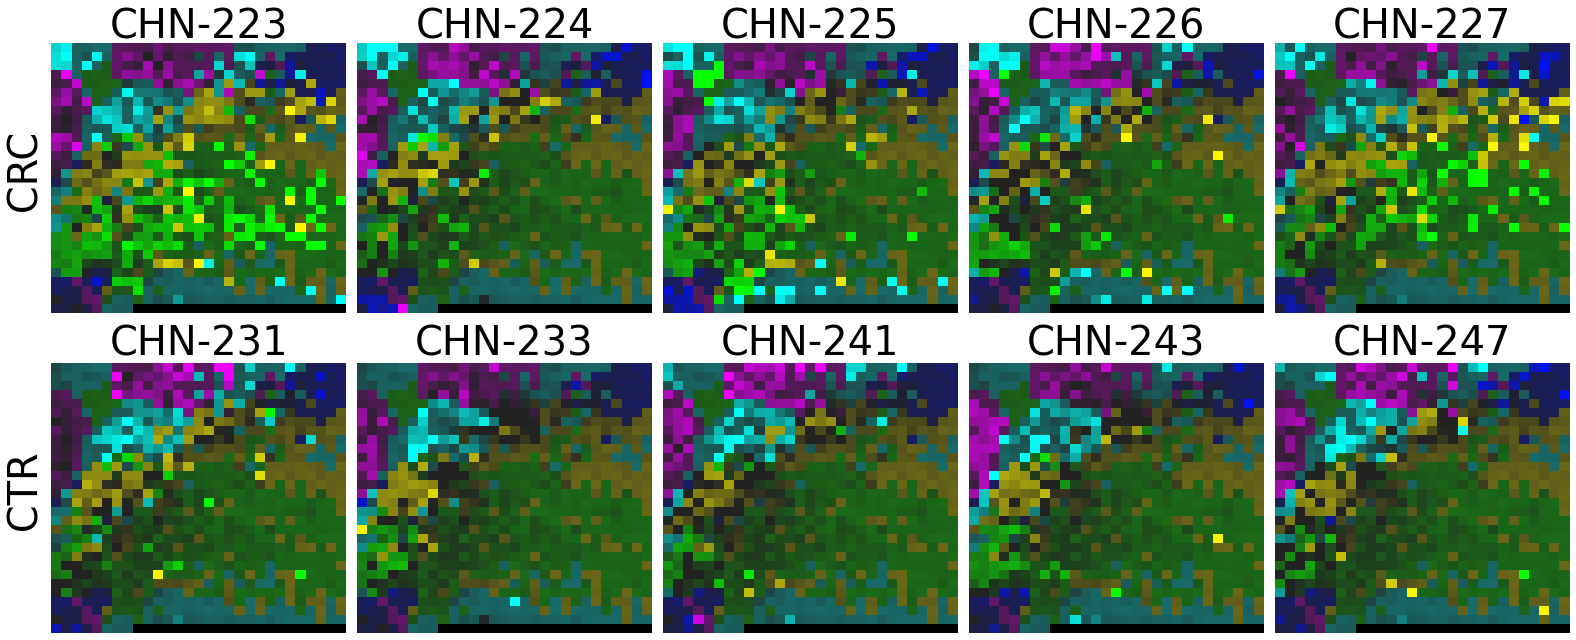

In [380]:
rows = idx.index.tolist()
rows = rows[2:4]
plot(rows, fname = './results/Country2_fmp.png')

## Country-3

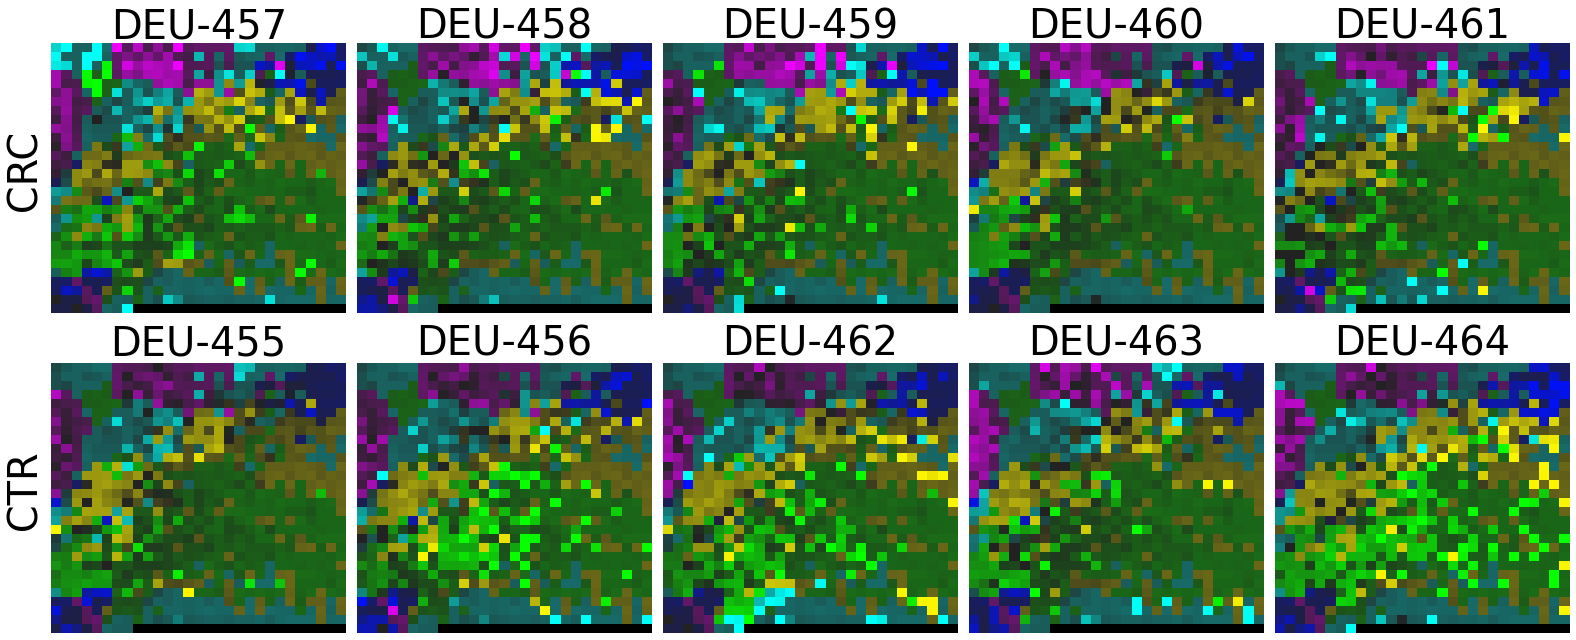

In [381]:
rows = idx.index.tolist()
rows = rows[4:6]
plot(rows, fname = './results/Country3_fmp.png')

## Country-4

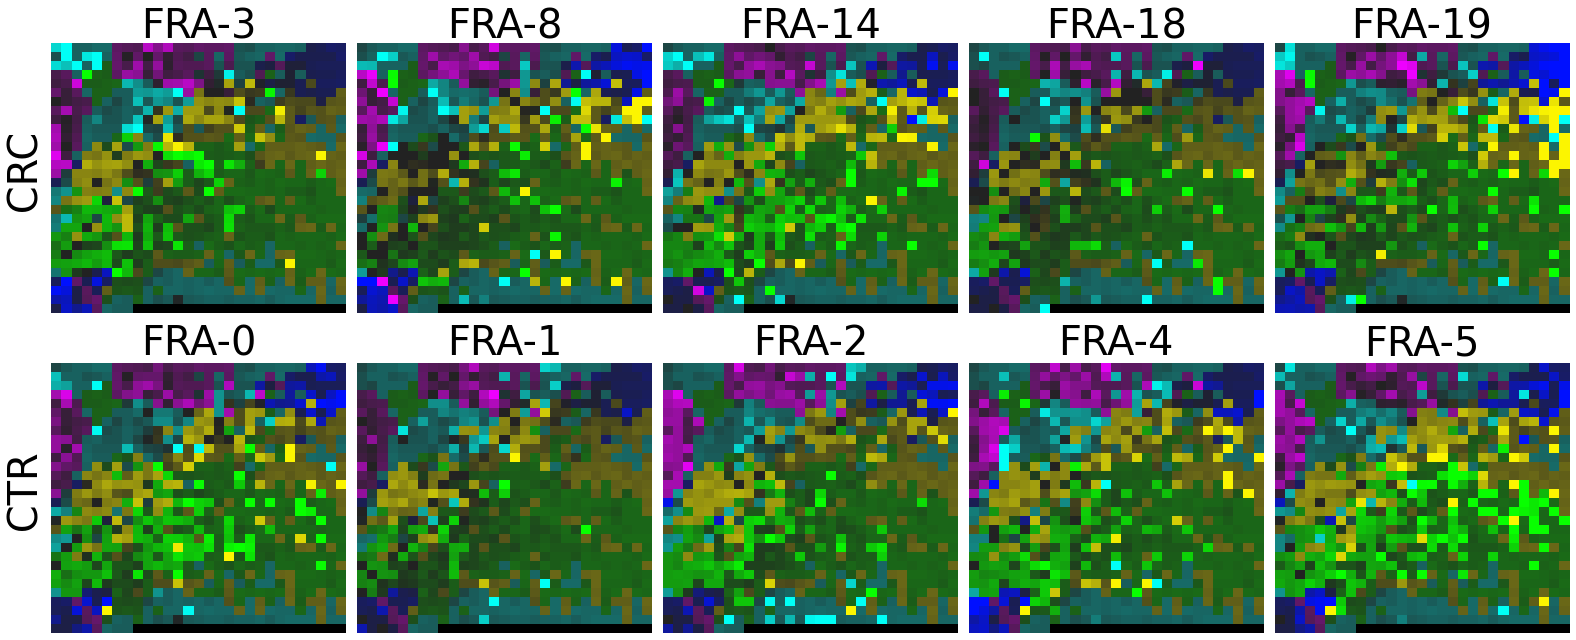

In [382]:
rows = idx.index.tolist()
rows = rows[6:8]
plot(rows, fname = './results/Country4_fmp.png')

## Country-5

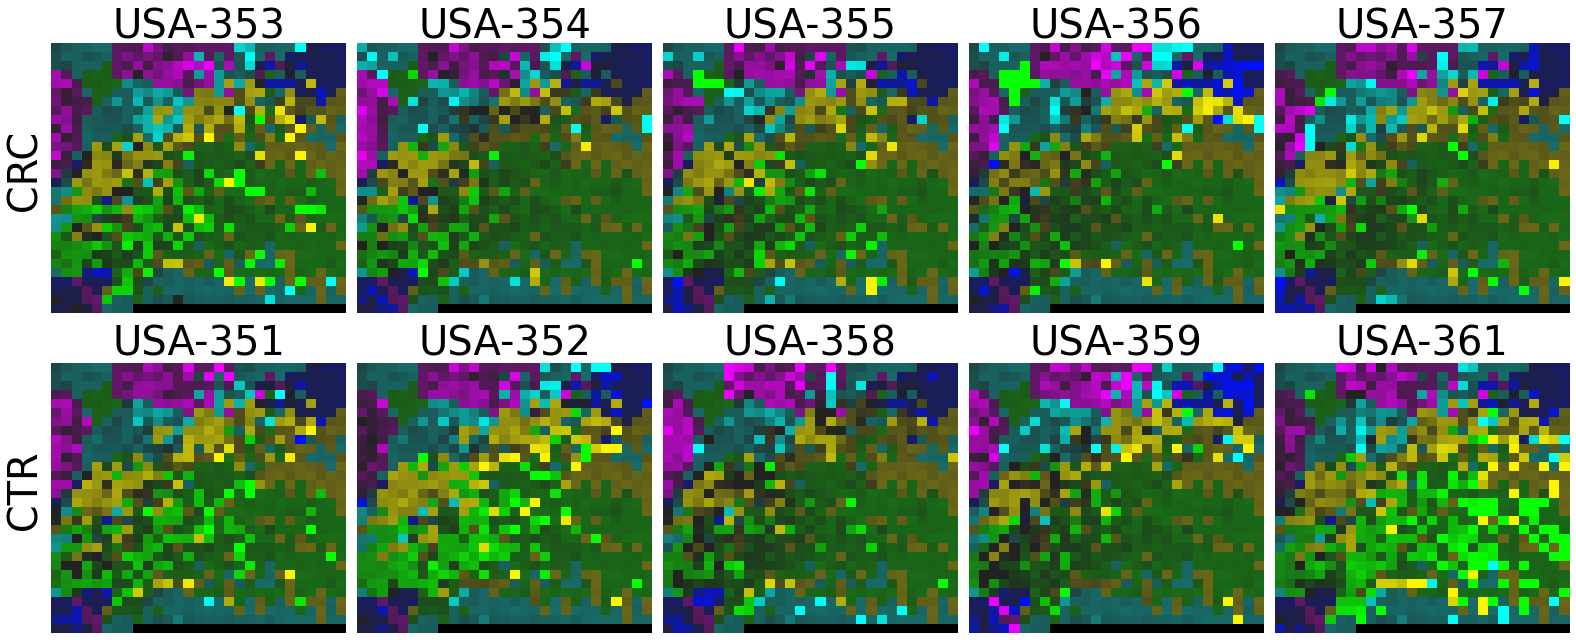

In [383]:
rows = idx.index.tolist()
rows = rows[8:10]
plot(rows, fname = './results/Country5_fmp.png')